In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer

import plotly.express as px
import plotly.graph_objects as go

import os
import re 
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

sns.set()

import matplotlib.pyplot as plt
import pandas as pd

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline

C:\Users\dinar\AppData\Local\Temp\ipykernel_18956\1232777852.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def show_plot(df, pred='preds'):
    agg_data = df.copy()
    agg_data.pricing_date = pd.to_datetime(agg_data.pricing_date)
    agg_data.forecast_date = agg_data.forecast_date.astype(str)

    agg_data = agg_data.set_index('pricing_date')

    df = agg_data.copy()
    df = df.sort_index(ascending=True)

    fig = px.line(df, x=df.index, y=pred, color='forecast_date', markers=True, height=600, width=1200)
    fig.update_traces(opacity=0.5, line=dict(width=2, ))

    df = agg_data.copy()
    df = df.sort_index(ascending=True)

    x = df.index
    y = df['target']
    name = 'target'
    fig.add_trace(
        go.Scatter(x=x, y=y, name=name, mode='lines+markers', opacity=0.5, marker=dict(color='darkgray', size=10),
                   line=dict(width=18, color='gray')))  # ,shape = 'hv'
    fig.show()
    

def show_results(results, save_path):
    thresh = 0.2

    results['nth_day'] = results.groupby('forecast_date')['preds'].cumcount()
    results['preds_diff'] = results.groupby('forecast_date')['preds'].diff()
    results['traget_diff'] = results.groupby('forecast_date')['target'].diff()
    results['preds_diff_cum'] = results.groupby('forecast_date')['preds_diff'].cumsum()
    results['traget_diff_cum'] = results.groupby('forecast_date')['traget_diff'].cumsum()
    results['preds_direct'] = results['preds_diff'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    results['traget_direct'] = results['traget_diff'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    results['preds_direct_cum'] = results['preds_diff_cum'].apply(
        lambda x: 1 if x > thresh else (-1 if x < -thresh else 0))
    results['traget_direct_cum'] = results['traget_diff_cum'].apply(
        lambda x: 1 if x > thresh else (-1 if x < -thresh else 0))
    results['pnl_stra_daily_direct'] = results['preds_direct'] * results['traget_diff']
    results['pnl_stra_cum_direct'] = results['preds_direct_cum'] * results['traget_diff_cum']

    fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
    results.pivot_table(index='pricing_date', values='pnl_stra_cum_direct', aggfunc=sum).cumsum().plot(ax=ax[0],
                                                                                                       title='pnl_stra_cum_direct')
    results.pivot_table(index='pricing_date', values='pnl_stra_daily_direct', aggfunc=sum).cumsum().plot(ax=ax[1],
                                                                                                         title='pnl_stra_daily_direct')
    fig.show()

In [3]:
def iterate(data, idx, step=100, low=False):
    # change step size if we have smaller input data
    step = 50 if low else 100

    # select starting point depending on the size of the input data
    start = idx * step if idx > 0 else 0

    # select ending point (if smaller, 300 days rolling window. Otherwise, 600)
    if low:
        end = 300 + step * idx
    else:
        end = 600 + step * idx

    train, val = data.iloc[start: start + end - 30, :], data.iloc[start + end - 30: start + end, :]
    return train, val


def custom_pnl_10(y_pred, y_true):
    nth = 10

    thresh = 0.2
    try:
        diff = y_pred[nth - 1] - y_pred[0]
    except IndexError:
        diff = y_pred[-1] - y_pred[0]

    direction = 1 if diff > thresh else (-1 if diff < thresh else 0)
    pnl = diff * direction

    return 'pnl', pnl



In [4]:

class TargetFeature:
    def __init__(self, results_path, data, test_start, test_end, target='F380 M2/M3',
                 feature='rolling_target5', **kwargs):
        self.results_path = results_path

        self.data = data
        self.test_start = test_start
        self.test_end = test_end
        self.target = target
        self.feature = feature

        # define pd.DataFrame to store resulting df
        self.target_and_feature = None

        # define scaler
        self.scaler = MinMaxScaler()

        # define a starting message for log
        self.message = 'Task 2 [TargetFeature]:\n\t'

    def __call__(self, *args, **kwargs):
        self._setup()

    def _setup(self):
        # self.log(self.log_path, f'{self.message}Internal setup for target and feature columns...')

        # get rolling feature
        rolling = self.data[self.target].ewm(span=30).mean()
        rolling.dropna(inplace=True)
        # self.log(self.log_path, f'Created rolling target.')

        # fit a scaler
        self.scaler.fit(rolling[:self.test_end].values.reshape(-1, 1))
        # self.log(self.log_path, f'Created a MinMaxScaler for rolling column.')

        # create a dataframe to store current state
        self.target_and_feature = pd.DataFrame({
            'actual_target': self.data[self.target],
            'actual_feature': rolling[:self.test_end],
            'predicted_target': np.nan,
            'predicted_feature': np.nan
        }, index=self.data.index)
        # self.log(self.log_path, f'Created a dataframe to store initial actual/predicted target and feature.')

        # fill in predicted target and feature until test_start date
        self.target_and_feature.loc[:self.test_start, 'predicted_target'] = self.data[self.target][:self.test_start]
        self.target_and_feature.loc[:self.test_start, 'predicted_feature'] = rolling[:self.test_start]
        # self.log(self.log_path, f'Setting previous predicted target/feature columns to actual values.')
        # self.log(self.log_path, f'{self.message}Finish setting up TargetFeature class instance.')

    def get_target_feature(self, end_date, start_date=None, include_past=False):
        # return all values until specified date
        if include_past:
            if start_date is not None:
                # self.log(self.log_path, f'Returning dates from {start_date} to {end_date}.')
                return self.target_and_feature.loc[start_date:end_date, :]
            # self.log(self.log_path, f'Returning all dates until {end_date}')
            return self.target_and_feature.loc[:end_date, :]

        # return one-day results
        try:
            entry = pd.DataFrame(self.target_and_feature.loc[end_date, :]).T
        except KeyError:
            # self.log(self.log_path, f'{self.message}Date {end_date} does not exist!', CRITICAL)
            raise KeyError(f'{self.message}Date {end_date} does not exist!')
        else:
            # self.log(self.log_path, f'Returned one-day instance for {end_date}.')
            return entry

    def set_target_feature(self, date, column, value):
        fmt = '%Y-%m-%d'

        # raise error if the supplemented date is less than the test start
        # if datetime.strptime(self.test_start, fmt) < datetime.strptime(date, fmt):
        #     message = f'Illegal date substitution {date}, expected to see dates between {self.test_start} to {date}.'
        #     self.log(self.log_path, self.message + message, CRITICAL)
        #     raise Exception(message)

        # get previous value
        previous = self.target_and_feature.loc[date, column]

        # log information
        # self.log(self.log_path, f'{self.message}Setting new value for {column}. Old: {previous}, new: {value}')

        # set new value
        self.target_and_feature.loc[date, column] = value

        # save current state
        # self.target_and_feature.reset_index(inplace=True)
        self.target_and_feature.to_csv(f'{self.results_path}/complete_target_feature_df.csv', index=True)
        # self.log(self.log_path, f'{self.message}Saving intermediate results in {self.results_path} CSV file.')


In [5]:
import xgboost as xgb

def train_model(data, test_start, test_end=None, target_col='F380 M2/M3', model_suffix='full', columns=None, 
                final_refit=True, path=None, use_rolling=False, n_estimators=1500):
    if columns is None and model_suffix == 'full':
        columns = [x for x in data.columns if x != target_col]
    elif columns is None and model_suffix != 'full':
        raise ValueError('Cannot train a subset of columns without specifying them! Please pass the columns ')
    
    # set the model name
    today_date = str(datetime.now())[:10]
    model_name = f'experiments/models/model-{model_suffix}-cols={len(columns)}_estim={n_estimators}.model'
    
    # create a target feature class
    target_feature = TargetFeature(path, data, test_start, test_end, target=target_col)
    target_feature()
    
    # drop target column
    data.drop(columns=[target_col], inplace=True)
    
    # data = data[columns]
    print('Data columns:', data.columns)
    
    # split to train/test
    train = data[data.index < test_start]
    
    if test_end:
        test = data[(data.index >= test_start) & (data.index < test_end)]
    else:
        test = data[data.index < test_end]
        
    # initiate normalization 
    scaler = MinMaxScaler()
    scaler.fit(train)
    
    # normalize data
    train = pd.DataFrame(scaler.transform(train), index=train.index, columns=train.columns)
    test = pd.DataFrame(scaler.transform(test), index=test.index, columns=train.columns)
    
    # get names for target_feature columns
    rolling, target = 'actual_feature', 'actual_target'
    
    # set parameters
    params = {'process_type': 'default', 'refresh_leaf': True, 'min_child_weight': 7,
              'subsample': 1, 'colsample_bytree': 0.5, 'eta': 0.03}
    
    # start pretraining the model
    for idx in range(300):
        # get batches
        train_temp, valid_temp = iterate(train, idx, low=False)

        # break if there are fewer values
        if len(train_temp) < 200 or len(valid_temp) <= 5: break

        # get rolling and target columns
        if use_rolling:
            train_temp[[target_col, 'rolling_target5']] = \
                target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                                include_past=True)[[target, rolling]].values
            valid_temp[[target_col, 'rolling_target5']] = \
                target_feature.get_target_feature(end_date=valid_temp.index.max(), start_date=valid_temp.index.min(),
                                                include_past=True)[[target, rolling]].values

            train_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
            valid_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
            train_temp.dropna(inplace=True)
            valid_temp.dropna(inplace=True)
            
            y_train = train_temp[target_col]
            y_test = valid_temp[target_col]
            
            train_temp.drop(columns=target_col, inplace=True)
            valid_temp.drop(columns=target_col, inplace=True)

            # normalize rolling
            train_temp['rolling_target5'] = target_feature.scaler.transform(train_temp[['rolling_target5']])
            valid_temp['rolling_target5'] = target_feature.scaler.transform(valid_temp[['rolling_target5']])
        else:
            y_train = target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                                include_past=True)[target].values
            y_test = target_feature.get_target_feature(end_date=valid_temp.index.max(), start_date=valid_temp.index.min(),
                                                include_past=True)[target].values

        # train_dm = xgb.DMatrix(train_temp.drop(columns=target_col), label=train_temp[target_col])
        # valid_dm = xgb.DMatrix(valid_temp.drop(columns=target_col), label=valid_temp[target_col])

        print(train_temp.shape, y_train.shape)
        print(valid_temp.shape, y_test.shape)

        if idx == 0:
            # model = xgb.train(params, train_dm, 100, evals=[(valid_dm, 'valid')],
            #                   maximize=True, early_stopping_rounds=10, custom_metric=custom_pnl_10)
            
            model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist')
            model.fit(train_temp, y_train, eval_set=[(valid_temp, y_test)], early_stopping_rounds=15, verbose=False)
            
        else:
            model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist', xgb_model=model_name)
            model.load_model(model_name)
            model.fit(train_temp, y_train, eval_set=[(valid_temp, y_test)], early_stopping_rounds=15, verbose=False)
            # model = xgb.train(params, train_dm, 100, evals=[(valid_dm, 'valid')],
            #                   maximize=True, early_stopping_rounds=10,
            #                   xgb_model=model_name, custom_metric=custom_pnl_10)

        model.save_model(model_name)

    # final refit
    full_train = train.copy()
    
    if use_rolling:
        full_train[[target_col, 'rolling_target5']] = target_feature.get_target_feature(end_date=train.index.max(),
                                                                                    include_past=True)[[target, rolling]].values
        # y_train = full_train[target_col]
        # full_train.drop(columns=target_col, inplace=True)
    else:
        full_train[target_col] = target_feature.get_target_feature(end_date=train.index.max(), include_past=True)[target].values
        
    full_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    full_train.dropna(inplace=True)
    
    y_train = full_train[target_col]
    full_train.drop(columns=target_col, inplace=True)

    if use_rolling:
        # normalize data
        full_train['rolling_target5'] = target_feature.scaler.transform(full_train[['rolling_target5']])

    # train_dm = xgb.DMatrix(full_train.drop(columns=target_col), label=full_train[target_col])
    
    model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist', xgb_model=model_name)
    model.load_model(model_name)
    model.fit(full_train, y_train, verbose=False)

    # model = xgb.train(params, train_dm, evals=[(train_dm, 'train')],
    #                   maximize=True, early_stopping_rounds=10,
    #                   xgb_model=model_name, custom_metric=custom_pnl_10)

    model.save_model(model_name)

    return model, train, test, scaler, target_feature, model_name


def get_columns(columns_selection, model):
    if columns_selection == 'xgboost':
        scores = model.get_score(importance_type='gain')
        temp_df = pd.DataFrame({'columns': scores.keys(), 'values': scores.values()})
        return temp_df[temp_df['values'] > 30]['columns'].to_list()


def get_predictions(data, results_folder, test_start, test_end, columns_selection='xgboost', use_rolling=False, n_estimators=1500, target_col='F380 M2/M3'):
    # model, train, test, scaler, target_feature = train_model(data.copy(), test_start=test_start, test_end=test_end, path=results_folder)

    # columns = get_columns(columns_selection, model)
    # print(columns)
    # columns = [x for x in columns if not x.startswith('rolling')]
    # print('Selected columns:', columns)
    columns = data.drop(columns=target_col).columns
    
    # refit the model with selected columns
    model, train, test, scaler, target_feature, model_name = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                             model_suffix='partial', columns=columns, path=results_folder, 
                                                             use_rolling=use_rolling, n_estimators=n_estimators, target_col=target_col)
    

    window_size = 10
    results_df = pd.DataFrame(columns=['pricing_date', 'preds', 'target', 'forecast_date'])
    market_data = data.copy()

    for counter in range(len(test)):
        try:
            sliding_history = market_data[market_data.index >= test_start].iloc[counter: counter + window_size, :]
        except IndexError:
            pass
        else:
            # verify the length of the sliding history == window_size
            if len(sliding_history) < window_size:
                break

            # copy original data
            full_history = market_data.copy()

            # keep track of every 0th value to select all actual targets and then predictions afterward
            first_day, second_day = None, None

            for counter2 in range(window_size):
                try:
                    sliding_start_date = pd.DataFrame(sliding_history.iloc[counter2, :]).T.index.values[0]

                    if counter2 == 1:
                        second_day = sliding_start_date

                except IndexError:
                    pass
                else:
                    expanding_history = full_history[full_history.index <= sliding_start_date]

                    # get test value and convert to DMatrix
                    testx = pd.DataFrame(expanding_history.iloc[-1, :]).T
                    testx = testx[columns]

                    # normalize features
                    testx = pd.DataFrame(scaler.transform(testx), columns=testx.columns, index=testx.index)

                    # select current state of the target/feature dataframe
                    current_values = target_feature.get_target_feature(sliding_start_date, include_past=True)
                    
                    # select actual values for the first predictions
                    if counter2 == 0:
                        current_targets = current_values['actual_target']
                    else:
                        current_targets = current_values['actual_target'].copy()
                        current_targets.loc[second_day:sliding_start_date] = current_values['predicted_target'].loc[
                                                                             second_day:sliding_start_date]
                    if use_rolling:
                        # get rolling targets
                        rolling_target = current_targets.ewm(span=30, adjust=True).mean()
                        rolling_target.dropna(inplace=True)
                        
                        # normalize rolling targets
                        try:
                            rolling_target = pd.DataFrame(target_feature.scaler.transform(rolling_target),
                                                        index=rolling_target.index)
                        except ValueError:
                            rolling_target = pd.DataFrame(
                                target_feature.scaler.transform(rolling_target.values.reshape(-1, 1)),
                                index=rolling_target.index)

                        # put the new value to test set
                        try:
                            testx['rolling_target5'] = rolling_target.iloc[-1, 0]
                        except KeyError:
                            pass
                            
                    # convert test to DMatrix
                    # test_dm = xgb.DMatrix(testx)
                    # testx.drop(columns='F380 M2/M3', inplace=True)

                    # get predictions
                    prediction = model.predict(testx)

                    # append new prediction to predicted target column
                    target_feature.set_target_feature(str(sliding_start_date)[:10], 'predicted_target', prediction)

                    if use_rolling:
                        # append new rolling value to the predicted feature column
                        inverse = target_feature.scaler.inverse_transform(testx[['rolling_target5']])
                        target_feature.set_target_feature(str(sliding_start_date)[:10], 'predicted_feature', inverse)

                    # record results
                    results_df = pd.concat([results_df, pd.DataFrame({
                        'pricing_date': testx.index,
                        'preds': prediction,
                        'target': current_values.loc[sliding_start_date, 'actual_target'],
                        'forecast_date': sliding_history.index.min()

                    })], ignore_index=True)
    results_df.to_csv(f'{results_folder}/results-for-{test_start}.csv')
    show_results(results_df, f'{results_folder}/daily_pnl-for-{test_start}.png')
    show_plot(results_df)

    return {'results_df': results_df, 'model': model, 'target_feature': target_feature, 
            'model_name': model_name, 'columns': columns, 'scaler': scaler}

In [6]:
def get_data(path, test_start, test_end, target='F380 M2/M3'):
    data = pd.read_csv(path)
    data.pricing_date = pd.to_datetime(data.pricing_date)
    data.set_index('pricing_date', inplace=True)
    data.interpolate('linear', inplace=True)
    
    # slice the dataset
    # data = data[data.index < test_end]
    return data

In [7]:
data = get_data('data/data_2024-02-02.csv', '2023-01-01', '2024-01-01')

data['year_sin'] = np.sin(data.index.year / data.index.year.max() * 2 * np.pi)
data['month_sin'] = np.sin(data.index.month / data.index.month.max() * 2 * np.pi)
data['day_sin'] = np.sin(data.index.day / data.index.day.max() * 2 * np.pi)
data['dow_sin'] = np.sin(data.index.dayofweek / data.index.dayofweek.max() * 2 * np.pi)

data['year_num'] = data.index.year
data['month_num'] = data.index.month
data['day_num'] = data.index.day
data['dow_num'] = data.index.dayofweek

data

,ALVARI,ARAMCOSG,ARAMCOTF,ARCENERGY,BBEN,BPSG,BRIGHTOILSG,BUYER1,BUYER2,CAOSG,...,_rgp_11_sz_3,F380 M2/M3,year_sin,month_sin,day_sin,dow_sin,year_num,month_num,day_num,dow_num
pricing_date,,,,,,,,,,,,,,,,,,,,,
2017-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.50,-2.172867e-02,0.500000,0.897805,1.000000e+00,2017,1,10,1
2017-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.30,-2.172867e-02,0.500000,0.790776,1.224647e-16,2017,1,11,2
2017-01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.70,-2.172867e-02,0.500000,0.651372,-1.000000e+00,2017,1,12,3
2017-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.85,-2.172867e-02,0.500000,0.485302,-2.449294e-16,2017,1,13,4
2017-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.00,-2.172867e-02,0.500000,-0.101168,0.000000e+00,2017,1,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.30,-2.449294e-16,0.866025,-0.848644,0.000000e+00,2024,2,26,0
2024-02-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.30,-2.449294e-16,0.866025,-0.724793,1.000000e+00,2024,2,27,1
2024-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.30,-2.449294e-16,0.866025,-0.571268,1.224647e-16,2024,2,28,2


In [8]:
import helpers

target_col = 'F380 M2/M3'
sequence = list(range(1, 11))

targets = data[[target_col]]
# targets = targets.merge(targets.shift([1, 3, 5, 10]), on='pricing_date
targets_df = helpers.add_columns(targets, 'F380 M2/M3', sequence=sequence)
targets_df
# targets_df[target_col] = targets.copy()

,F380 M2/M3+1,F380 M2/M3+2,F380 M2/M3+3,F380 M2/M3+4,F380 M2/M3+5,F380 M2/M3+6,F380 M2/M3+7,F380 M2/M3+8,F380 M2/M3+9,F380 M2/M3+10
pricing_date,,,,,,,,,,
2017-01-10,1.3,1.7,1.85,2.0,1.65,1.45,1.2,0.85,1.2,0.8
2017-01-11,1.7,1.85,2.0,1.65,1.45,1.2,0.85,1.2,0.8,0.15
2017-01-12,1.85,2.0,1.65,1.45,1.2,0.85,1.2,0.8,0.15,0.15
2017-01-13,2.0,1.65,1.45,1.2,0.85,1.2,0.8,0.15,0.15,0.2
2017-01-16,1.65,1.45,1.2,0.85,1.2,0.8,0.15,0.15,0.2,-0.275
...,...,...,...,...,...,...,...,...,...,...
2024-02-26,-0.3,-0.3,-0.3,-0.3,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-27,-0.3,-0.3,-0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-28,-0.3,-0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
new_df = pd.DataFrame(index=data.index)

sequence = list(range(1, 11))

for col in data.drop(columns=target_col).columns:
    new_df = pd.concat([new_df, data[col]], axis=1)
    new_df = pd.concat([new_df, helpers.add_columns(data, col, sequence=sequence)], axis=1)
    
new_df

,ALVARI,ALVARI+1,ALVARI+2,ALVARI+3,ALVARI+4,ALVARI+5,ALVARI+6,ALVARI+7,ALVARI+8,ALVARI+9,...,dow_num+1,dow_num+2,dow_num+3,dow_num+4,dow_num+5,dow_num+6,dow_num+7,dow_num+8,dow_num+9,dow_num+10
pricing_date,,,,,,,,,,,,,,,,,,,,,
2017-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0
2017-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0
2017-01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0
2017-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0
2017-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,3.0,4.0,0.0,1.0,2.0,3.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,1.0,2.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-27,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-28,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
new_df = new_df.loc['2017-01-10':'2023-12-29']
targets_df = targets_df.loc['2017-01-10':'2023-12-29']

new_df.shape, targets_df.shape

((1819, 814), (1819, 10))

In [11]:
targets_df

,F380 M2/M3+1,F380 M2/M3+2,F380 M2/M3+3,F380 M2/M3+4,F380 M2/M3+5,F380 M2/M3+6,F380 M2/M3+7,F380 M2/M3+8,F380 M2/M3+9,F380 M2/M3+10
pricing_date,,,,,,,,,,
2017-01-10,1.3,1.7,1.85,2.0,1.65,1.45,1.2,0.85,1.2,0.8
2017-01-11,1.7,1.85,2.0,1.65,1.45,1.2,0.85,1.2,0.8,0.15
2017-01-12,1.85,2.0,1.65,1.45,1.2,0.85,1.2,0.8,0.15,0.15
2017-01-13,2.0,1.65,1.45,1.2,0.85,1.2,0.8,0.15,0.15,0.2
2017-01-16,1.65,1.45,1.2,0.85,1.2,0.8,0.15,0.15,0.2,-0.275
...,...,...,...,...,...,...,...,...,...,...
2023-12-25,2.95,3.15,3.45,3.55,3.275,3.0,3.85,3.5,3.5,2.75
2023-12-26,3.15,3.45,3.55,3.275,3.0,3.85,3.5,3.5,2.75,2.75
2023-12-27,3.45,3.55,3.275,3.0,3.85,3.5,3.5,2.75,2.75,2.75


Data columns: Index(['ALVARI', 'ALVARI+1', 'ALVARI+2', 'ALVARI+3', 'ALVARI+4', 'ALVARI+5',
       'ALVARI+6', 'ALVARI+7', 'ALVARI+8', 'ALVARI+9',
       ...
       'dow_num+1', 'dow_num+2', 'dow_num+3', 'dow_num+4', 'dow_num+5',
       'dow_num+6', 'dow_num+7', 'dow_num+8', 'dow_num+9', 'dow_num+10'],
      dtype='object', length=814)
(570, 814) (570,)
(30, 814) (30,)
(670, 814) (670,)
(30, 814) (30,)
(770, 814) (770,)
(30, 814) (30,)
(870, 814) (870,)
(30, 814) (30,)
(970, 814) (970,)
(30, 814) (30,)


Changing class type to XGBRegressionExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
Generating layout...
Calculating shap values...


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:ALVARI+1: category, ALVARI+2: category, ALVARI+3: category, ALVARI+4: category, ALVARI+5: category, ALVARI+6: category, ALVARI+7: category, ALVARI+8: category, ALVARI+9: category, ALVARI+10: category, ARAMCOSG+1: category, ARAMCOSG+2: category, ARAMCOSG+3: category, ARAMCOSG+4: category, ARAMCOSG+5: category, ARAMCOSG+6: category, ARAMCOSG+7: category, ARAMCOSG+8: category, ARAMCOSG+9: category, ARAMCOSG+10: category, ARAMCOTF+1: category, ARAMCOTF+2: category, ARAMCOTF+3: category, ARAMCOTF+4: category, ARAMCOTF+5: category, ARAMCOTF+6: category, ARAMCOTF+7: category, ARAMCOTF+8: category, ARAMCOTF+9: category, ARAMCOTF+10: category, ARCENERGY+1: category, ARCENERGY+2: category, ARCENERGY+3: category, ARCENERGY+4: category, ARCENERGY+5: category, ARCENERGY+6: category, ARCENERGY+7: category, ARCENERGY+8: category, ARCENERGY+9: category, ARCENERGY+10: category, BBEN+1: category, BBEN+2: category, BBEN+3: category, BBEN+4: category, BBEN+5: category, BBEN+6: category, BBEN+7: category, BBEN+8: category, BBEN+9: category, BBEN+10: category, BPSG+1: category, BPSG+2: category, BPSG+3: category, BPSG+4: category, BPSG+5: category, BPSG+6: category, BPSG+7: category, BPSG+8: category, BPSG+9: category, BPSG+10: category, BRIGHTOILSG+1: category, BRIGHTOILSG+2: category, BRIGHTOILSG+3: category, BRIGHTOILSG+4: category, BRIGHTOILSG+5: category, BRIGHTOILSG+6: category, BRIGHTOILSG+7: category, BRIGHTOILSG+8: category, BRIGHTOILSG+9: category, BRIGHTOILSG+10: category, BUYER1+1: category, BUYER1+2: category, BUYER1+3: category, BUYER1+4: category, BUYER1+5: category, BUYER1+6: category, BUYER1+7: category, BUYER1+8: category, BUYER1+9: category, BUYER1+10: category, BUYER2+1: category, BUYER2+2: category, BUYER2+3: category, BUYER2+4: category, BUYER2+5: category, BUYER2+6: category, BUYER2+7: category, BUYER2+8: category, BUYER2+9: category, BUYER2+10: category, CAOSG+1: category, CAOSG+2: category, CAOSG+3: category, CAOSG+4: category, CAOSG+5: category, CAOSG+6: category, CAOSG+7: category, CAOSG+8: category, CAOSG+9: category, CAOSG+10: category, CARGILLSG+1: category, CARGILLSG+2: category, CARGILLSG+3: category, CARGILLSG+4: category, CARGILLSG+5: category, CARGILLSG+6: category, CARGILLSG+7: category, CARGILLSG+8: category, CARGILLSG+9: category, CARGILLSG+10: category, CCMA+1: category, CCMA+2: category, CCMA+3: category, CCMA+4: category, CCMA+5: category, CCMA+6: category, CCMA+7: category, CCMA+8: category, CCMA+9: category, CCMA+10: category, CHEVRONSG+1: category, CHEVRONSG+2: category, CHEVRONSG+3: category, CHEVRONSG+4: category, CHEVRONSG+5: category, CHEVRONSG+6: category, CHEVRONSG+7: category, CHEVRONSG+8: category, CHEVRONSG+9: category, CHEVRONSG+10: category, COASTAL+1: category, COASTAL+2: category, COASTAL+3: category, COASTAL+4: category, COASTAL+5: category, COASTAL+6: category, COASTAL+7: category, COASTAL+8: category, COASTAL+9: category, COASTAL+10: category, ENEOSSG+1: category, ENEOSSG+2: category, ENEOSSG+3: category, ENEOSSG+4: category, ENEOSSG+5: category, ENEOSSG+6: category, ENEOSSG+7: category, ENEOSSG+8: category, ENEOSSG+9: category, ENEOSSG+10: category, ENOC+1: category, ENOC+2: category, ENOC+3: category, ENOC+4: category, ENOC+5: category, ENOC+6: category, ENOC+7: category, ENOC+8: category, ENOC+9: category, ENOC+10: category, FREEPTSG+1: category, FREEPTSG+2: category, FREEPTSG+3: category, FREEPTSG+4: category, FREEPTSG+5: category, FREEPTSG+6: category, FREEPTSG+7: category, FREEPTSG+8: category, FREEPTSG+9: category, FREEPTSG+10: category, GLENCORESG+1: category, GLENCORESG+2: category, GLENCORESG+3: category, GLENCORESG+4: category, GLENCORESG+5: category, GLENCORESG+6: category, GLENCORESG+7: category, GLENCORESG+8: category, GLENCORESG+9: category, GLENCORESG+10: category, GPGLOBALSG+1: category, GPGLOBALSG+2: category, GPGLOBALSG+3: category, GPGLOBALSG+4: category, GPGLOBALSG+5: category, GPGLOBALSG+6: category, GPGLOBALSG+7: category, GPGLOBALSG+8: category, GPGLOBALSG+9: category, GPGLOBALSG+10: category, GULFSG+1: category, GULFSG+2: category, GULFSG+3: category, GULFSG+4: category, GULFSG+5: category, GULFSG+6: category, GULFSG+7: category, GULFSG+8: category, GULFSG+9: category, GULFSG+10: category, GUNVORSG+1: category, GUNVORSG+2: category, GUNVORSG+3: category, GUNVORSG+4: category, GUNVORSG+5: category, GUNVORSG+6: category, GUNVORSG+7: category, GUNVORSG+8: category, GUNVORSG+9: category, GUNVORSG+10: category, HL+1: category, HL+2: category, HL+3: category, HL+4: category, HL+5: category, HL+6: category, HL+7: category, HL+8: category, HL+9: category, HL+10: category, IDEMITSU+1: category, IDEMITSU+2: category, IDEMITSU+3: category, IDEMITSU+4: category, IDEMITSU+5: category, IDEMITSU+6: category, IDEMITSU+7: category, IDEMITSU+8: category, IDEMITSU+9: category, IDEMITSU+10: category, ITGRES+1: category, ITGRES+2: category, ITGRES+3: category, ITGRES+4: category, ITGRES+5: category, ITGRES+6: category, ITGRES+7: category, ITGRES+8: category, ITGRES+9: category, ITGRES+10: category, KAIROS+1: category, KAIROS+2: category, KAIROS+3: category, KAIROS+4: category, KAIROS+5: category, KAIROS+6: category, KAIROS+7: category, KAIROS+8: category, KAIROS+9: category, KAIROS+10: category, KOCHRI+1: category, KOCHRI+2: category, KOCHRI+3: category, KOCHRI+4: category, KOCHRI+5: category, KOCHRI+6: category, KOCHRI+7: category, KOCHRI+8: category, KOCHRI+9: category, KOCHRI+10: category, LUKOIL+1: category, LUKOIL+2: category, LUKOIL+3: category, LUKOIL+4: category, LUKOIL+5: category, LUKOIL+6: category, LUKOIL+7: category, LUKOIL+8: category, LUKOIL+9: category, LUKOIL+10: category, MACQUARIESG+1: category, MACQUARIESG+2: category, MACQUARIESG+3: category, MACQUARIESG+4: category, MACQUARIESG+5: category, MACQUARIESG+6: category, MACQUARIESG+7: category, MACQUARIESG+8: category, MACQUARIESG+9: category, MACQUARIESG+10: category, MAERSKSG+1: category, MAERSKSG+2: category, MAERSKSG+3: category, MAERSKSG+4: category, MAERSKSG+5: category, MAERSKSG+6: category, MAERSKSG+7: category, MAERSKSG+8: category, MAERSKSG+9: category, MAERSKSG+10: category, MERCURIARESOURCES+1: category, MERCURIARESOURCES+2: category, MERCURIARESOURCES+3: category, MERCURIARESOURCES+4: category, MERCURIARESOURCES+5: category, MERCURIARESOURCES+6: category, MERCURIARESOURCES+7: category, MERCURIARESOURCES+8: category, MERCURIARESOURCES+9: category, MERCURIARESOURCES+10: category, MERCURIASG+1: category, MERCURIASG+2: category, MERCURIASG+3: category, MERCURIASG+4: category, MERCURIASG+5: category, MERCURIASG+6: category, MERCURIASG+7: category, MERCURIASG+8: category, MERCURIASG+9: category, MERCURIASG+10: category, METS+1: category, METS+2: category, METS+3: category, METS+4: category, METS+5: category, METS+6: category, METS+7: category, METS+8: category, METS+9: category, METS+10: category, MIPCO+1: category, MIPCO+2: category, MIPCO+3: category, MIPCO+4: category, MIPCO+5: category, MIPCO+6: category, MIPCO+7: category, MIPCO+8: category, MIPCO+9: category, MIPCO+10: category, P66SG+1: category, P66SG+2: category, P66SG+3: category, P66SG+4: category, P66SG+5: category, P66SG+6: category, P66SG+7: category, P66SG+8: category, P66SG+9: category, P66SG+10: category, PETCO+1: category, PETCO+2: category, PETCO+3: category, PETCO+4: category, PETCO+5: category, PETCO+6: category, PETCO+7: category, PETCO+8: category, PETCO+9: category, PETCO+10: category, PETROCHINA+1: category, PETROCHINA+2: category, PETROCHINA+3: category, PETROCHINA+4: category, PETROCHINA+5: category, PETROCHINA+6: category, PETROCHINA+7: category, PETROCHINA+8: category, PETROCHINA+9: category, PETROCHINA+10: category, PETROSUMMIT+1: category, PETROSUMMIT+2: category, PETROSUMMIT+3: category, PETROSUMMIT+4: category, PETROSUMMIT+5: category, PETROSUMMIT+6: category, PETROSUMMIT+7: category, PETROSUMMIT+8: category, PETROSUMMIT+9: category, PETROSUMMIT+10: category, PTT+1: category, PTT+2: category, PTT+3: category, PTT+4: category, PTT+5: category, PTT+6: category, PTT+7: category, PTT+8: category, PTT+9: category, PTT+10: category, REPSOLSG+1: category, REPSOLSG+2: category, REPSOLSG+3: category, REPSOLSG+4: category, REPSOLSG+5: category, REPSOLSG+6: category, REPSOLSG+7: category, REPSOLSG+8: category, REPSOLSG+9: category, REPSOLSG+10: category, REXCOMM+1: category, REXCOMM+2: category, REXCOMM+3: category, REXCOMM+4: category, REXCOMM+5: category, REXCOMM+6: category, REXCOMM+7: category, REXCOMM+8: category, REXCOMM+9: category, REXCOMM+10: category, RGES+1: category, RGES+2: category, RGES+3: category, RGES+4: category, RGES+5: category, RGES+6: category, RGES+7: category, RGES+8: category, RGES+9: category, RGES+10: category, SELLER1+1: category, SELLER1+2: category, SELLER1+3: category, SELLER1+4: category, SELLER1+5: category, SELLER1+6: category, SELLER1+7: category, SELLER1+8: category, SELLER1+9: category, SELLER1+10: category, SIETCO+1: category, SIETCO+2: category, SIETCO+3: category, SIETCO+4: category, SIETCO+5: category, SIETCO+6: category, SIETCO+7: category, SIETCO+8: category, SIETCO+9: category, SIETCO+10: category, SINOHKPET+1: category, SINOHKPET+2: category, SINOHKPET+3: category, SINOHKPET+4: category, SINOHKPET+5: category, SINOHKPET+6: category, SINOHKPET+7: category, SINOHKPET+8: category, SINOHKPET+9: category, SINOHKPET+10: category, SINOPECFO+1: category, SINOPECFO+2: category, SINOPECFO+3: category, SINOPECFO+4: category, SINOPECFO+5: category, SINOPECFO+6: category, SINOPECFO+7: category, SINOPECFO+8: category, SINOPECFO+9: category, SINOPECFO+10: category, SINOPECHKSG+1: category, SINOPECHKSG+2: category, SINOPECHKSG+3: category, SINOPECHKSG+4: category, SINOPECHKSG+5: category, SINOPECHKSG+6: category, SINOPECHKSG+7: category, SINOPECHKSG+8: category, SINOPECHKSG+9: category, SINOPECHKSG+10: category, SKEISG+1: category, SKEISG+2: category, SKEISG+3: category, SKEISG+4: category, SKEISG+5: category, SKEISG+6: category, SKEISG+7: category, SKEISG+8: category, SKEISG+9: category, SKEISG+10: category, SOCAR+1: category, SOCAR+2: category, SOCAR+3: category, SOCAR+4: category, SOCAR+5: category, SOCAR+6: category, SOCAR+7: category, SOCAR+8: category, SOCAR+9: category, SOCAR+10: category, SUMMITENERGY+1: category, SUMMITENERGY+2: category, SUMMITENERGY+3: category, SUMMITENERGY+4: category, SUMMITENERGY+5: category, SUMMITENERGY+6: category, SUMMITENERGY+7: category, SUMMITENERGY+8: category, SUMMITENERGY+9: category, SUMMITENERGY+10: category, TOTALSG+1: category, TOTALSG+2: category, TOTALSG+3: category, TOTALSG+4: category, TOTALSG+5: category, TOTALSG+6: category, TOTALSG+7: category, TOTALSG+8: category, TOTALSG+9: category, TOTALSG+10: category, TRAFI+1: category, TRAFI+2: category, TRAFI+3: category, TRAFI+4: category, TRAFI+5: category, TRAFI+6: category, TRAFI+7: category, TRAFI+8: category, TRAFI+9: category, TRAFI+10: category, UNIPECSG+1: category, UNIPECSG+2: category, UNIPECSG+3: category, UNIPECSG+4: category, UNIPECSG+5: category, UNIPECSG+6: category, UNIPECSG+7: category, UNIPECSG+8: category, UNIPECSG+9: category, UNIPECSG+10: category, VITOLSG+1: category, VITOLSG+2: category, VITOLSG+3: category, VITOLSG+4: category, VITOLSG+5: category, VITOLSG+6: category, VITOLSG+7: category, VITOLSG+8: category, VITOLSG+9: category, VITOLSG+10: category, WANXIANG+1: category, WANXIANG+2: category, WANXIANG+3: category, WANXIANG+4: category, WANXIANG+5: category, WANXIANG+6: category, WANXIANG+7: category, WANXIANG+8: category, WANXIANG+9: category, WANXIANG+10: category, ZENROCK+1: category, ZENROCK+2: category, ZENROCK+3: category, ZENROCK+4: category, ZENROCK+5: category, ZENROCK+6: category, ZENROCK+7: category, ZENROCK+8: category, ZENROCK+9: category, ZENROCK+10: category, _rgp_01_sz_3+1: category, _rgp_01_sz_3+2: category, _rgp_01_sz_3+3: category, _rgp_01_sz_3+4: category, _rgp_01_sz_3+5: category, _rgp_01_sz_3+6: category, _rgp_01_sz_3+7: category, _rgp_01_sz_3+8: category, _rgp_01_sz_3+9: category, _rgp_01_sz_3+10: category, _rgp_02_sz_3+1: category, _rgp_02_sz_3+2: category, _rgp_02_sz_3+3: category, _rgp_02_sz_3+4: category, _rgp_02_sz_3+5: category, _rgp_02_sz_3+6: category, _rgp_02_sz_3+7: category, _rgp_02_sz_3+8: category, _rgp_02_sz_3+9: category, _rgp_02_sz_3+10: category, _rgp_03_sz_3+1: category, _rgp_03_sz_3+2: category, _rgp_03_sz_3+3: category, _rgp_03_sz_3+4: category, _rgp_03_sz_3+5: category, _rgp_03_sz_3+6: category, _rgp_03_sz_3+7: category, _rgp_03_sz_3+8: category, _rgp_03_sz_3+9: category, _rgp_03_sz_3+10: category, _rgp_04_sz_3+1: category, _rgp_04_sz_3+2: category, _rgp_04_sz_3+3: category, _rgp_04_sz_3+4: category, _rgp_04_sz_3+5: category, _rgp_04_sz_3+6: category, _rgp_04_sz_3+7: category, _rgp_04_sz_3+8: category, _rgp_04_sz_3+9: category, _rgp_04_sz_3+10: category, _rgp_05_sz_3+1: category, _rgp_05_sz_3+2: category, _rgp_05_sz_3+3: category, _rgp_05_sz_3+4: category, _rgp_05_sz_3+5: category, _rgp_05_sz_3+6: category, _rgp_05_sz_3+7: category, _rgp_05_sz_3+8: category, _rgp_05_sz_3+9: category, _rgp_05_sz_3+10: category, _rgp_06_sz_3+1: category, _rgp_06_sz_3+2: category, _rgp_06_sz_3+3: category, _rgp_06_sz_3+4: category, _rgp_06_sz_3+5: category, _rgp_06_sz_3+6: category, _rgp_06_sz_3+7: category, _rgp_06_sz_3+8: category, _rgp_06_sz_3+9: category, _rgp_06_sz_3+10: category, _rgp_07_sz_3+1: category, _rgp_07_sz_3+2: category, _rgp_07_sz_3+3: category, _rgp_07_sz_3+4: category, _rgp_07_sz_3+5: category, _rgp_07_sz_3+6: category, _rgp_07_sz_3+7: category, _rgp_07_sz_3+8: category, _rgp_07_sz_3+9: category, _rgp_07_sz_3+10: category, _rgp_08_sz_3+1: category, _rgp_08_sz_3+2: category, _rgp_08_sz_3+3: category, _rgp_08_sz_3+4: category, _rgp_08_sz_3+5: category, _rgp_08_sz_3+6: category, _rgp_08_sz_3+7: category, _rgp_08_sz_3+8: category, _rgp_08_sz_3+9: category, _rgp_08_sz_3+10: category, _rgp_09_sz_3+1: category, _rgp_09_sz_3+2: category, _rgp_09_sz_3+3: category, _rgp_09_sz_3+4: category, _rgp_09_sz_3+5: category, _rgp_09_sz_3+6: category, _rgp_09_sz_3+7: category, _rgp_09_sz_3+8: category, _rgp_09_sz_3+9: category, _rgp_09_sz_3+10: category, _rgp_10_sz_3+1: category, _rgp_10_sz_3+2: category, _rgp_10_sz_3+3: category, _rgp_10_sz_3+4: category, _rgp_10_sz_3+5: category, _rgp_10_sz_3+6: category, _rgp_10_sz_3+7: category, _rgp_10_sz_3+8: category, _rgp_10_sz_3+9: category, _rgp_10_sz_3+10: category, _rgp_11_sz_3+1: category, _rgp_11_sz_3+2: category, _rgp_11_sz_3+3: category, _rgp_11_sz_3+4: category, _rgp_11_sz_3+5: category, _rgp_11_sz_3+6: category, _rgp_11_sz_3+7: category, _rgp_11_sz_3+8: category, _rgp_11_sz_3+9: category, _rgp_11_sz_3+10: category, year_sin+1: category, year_sin+2: category, year_sin+3: category, year_sin+4: category, year_sin+5: category, year_sin+6: category, year_sin+7: category, year_sin+8: category, year_sin+9: category, year_sin+10: category, month_sin+1: category, month_sin+2: category, month_sin+3: category, month_sin+4: category, month_sin+5: category, month_sin+6: category, month_sin+7: category, month_sin+8: category, month_sin+9: category, month_sin+10: category, day_sin+1: category, day_sin+2: category, day_sin+3: category, day_sin+4: category, day_sin+5: category, day_sin+6: category, day_sin+7: category, day_sin+8: category, day_sin+9: category, day_sin+10: category, dow_sin+1: category, dow_sin+2: category, dow_sin+3: category, dow_sin+4: category, dow_sin+5: category, dow_sin+6: category, dow_sin+7: category, dow_sin+8: category, dow_sin+9: category, dow_sin+10: category, year_num+1: category, year_num+2: category, year_num+3: category, year_num+4: category, year_num+5: category, year_num+6: category, year_num+7: category, year_num+8: category, year_num+9: category, year_num+10: category, month_num+1: category, month_num+2: category, month_num+3: category, month_num+4: category, month_num+5: category, month_num+6: category, month_num+7: category, month_num+8: category, month_num+9: category, month_num+10: category, day_num+1: category, day_num+2: category, day_num+3: category, day_num+4: category, day_num+5: category, day_num+6: category, day_num+7: category, day_num+8: category, day_num+9: category, day_num+10: category, dow_num+1: category, dow_num+2: category, dow_num+3: category, dow_num+4: category, dow_num+5: category, dow_num+6: category, dow_num+7: category, dow_num+8: category, dow_num+9: category, dow_num+10: category

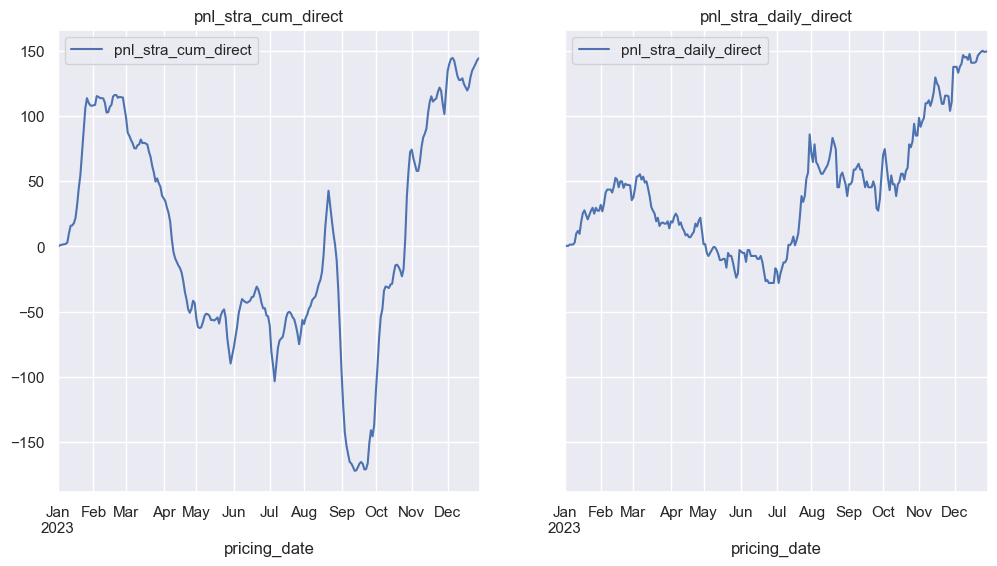

In [17]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard

target_col = 'target+1'

new_df['target+1'] = targets_df.loc[:, 'F380 M2/M3+1'].values


results = get_predictions(new_df.copy(), 'experiments/', test_start='2023-01-01', test_end='2023-12-31',
                          use_rolling=False, n_estimators=100, target_col='target+1')

test = new_df[(new_df.index >= '2023-01-01') & (new_df.index <= '2023-12-31')]
X_test, y_test = test.drop(columns=target_col), test[target_col]

X_test = X_test.astype('float64')
explainer = RegressionExplainer(results['model'], X_test, y_test)
ExplainerDashboard(explainer, depth=5).run()

### T + 10

Data columns: Index(['ALVARI', 'ALVARI+1', 'ALVARI+2', 'ALVARI+3', 'ALVARI+4', 'ALVARI+5',
       'ALVARI+6', 'ALVARI+7', 'ALVARI+8', 'ALVARI+9',
       ...
       'dow_num+1', 'dow_num+2', 'dow_num+3', 'dow_num+4', 'dow_num+5',
       'dow_num+6', 'dow_num+7', 'dow_num+8', 'dow_num+9', 'dow_num+10'],
      dtype='object', length=814)
(570, 814) (570,)
(30, 814) (30,)
(670, 814) (670,)
(30, 814) (30,)
(770, 814) (770,)
(30, 814) (30,)
(870, 814) (870,)
(30, 814) (30,)
(970, 814) (970,)
(30, 814) (30,)


Changing class type to XGBRegressionExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calculating shap values...
Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating shap interaction values...
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Generating xgboost model dump...
Calculating dependencies...
Calculating importances...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExpla

ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=8050): Max retries exceeded with url: /_alive_12072eb5-61cc-44c9-b717-fb9bc51d3e72 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000024A06AE68F0>: Failed to establish a new connection: [WinError 10049] Требуемый адрес для своего контекста неверен'))

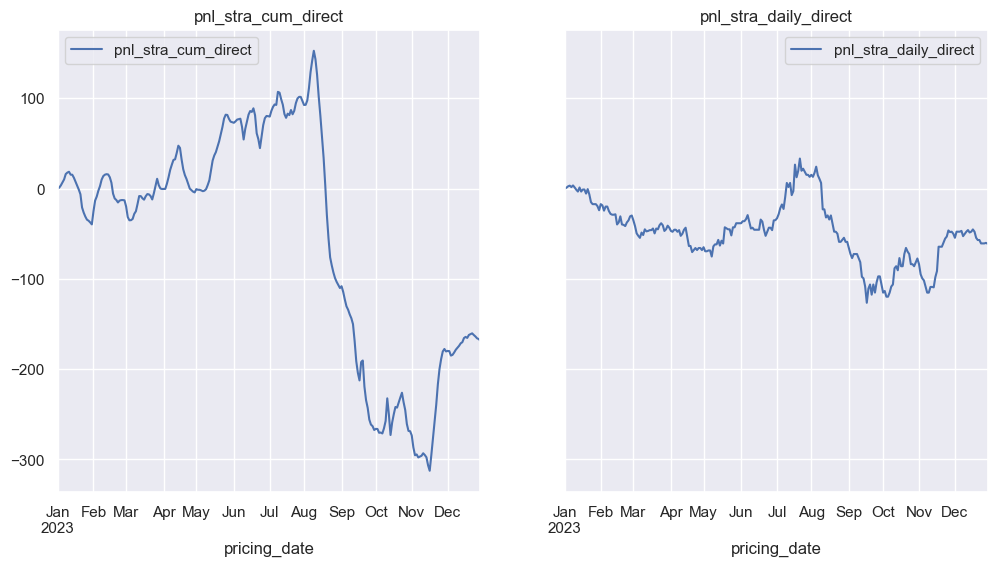

In [15]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard

target_col = 'target+10'

new_df[target_col] = targets_df.loc[:, 'F380 M2/M3+10'].values


results = get_predictions(new_df.copy(), 'experiments/', test_start='2023-01-01', test_end='2023-12-31',
                          use_rolling=False, n_estimators=100, target_col=target_col)

test = new_df[(new_df.index >= '2023-01-01') & (new_df.index <= '2023-12-31')]
X_test, y_test = test.drop(columns=target_col), test[target_col]

X_test = X_test.astype('float64')
explainer = RegressionExplainer(results['model'], X_test, y_test)
ExplainerDashboard(explainer, depth=2).run()

Data columns: Index(['ALVARI', 'ALVARI+1', 'ALVARI+2', 'ALVARI+3', 'ALVARI+4', 'ALVARI+5',
       'ALVARI+6', 'ALVARI+7', 'ALVARI+8', 'ALVARI+9',
       ...
       'dow_num+1', 'dow_num+2', 'dow_num+3', 'dow_num+4', 'dow_num+5',
       'dow_num+6', 'dow_num+7', 'dow_num+8', 'dow_num+9', 'dow_num+10'],
      dtype='object', length=814)
(570, 815) (570,)
(30, 815) (30,)
(670, 815) (670,)
(30, 815) (30,)
(770, 815) (770,)
(30, 815) (30,)
(870, 815) (870,)
(30, 815) (30,)
(970, 815) (970,)
(30, 815) (30,)


Changing class type to XGBRegressionExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calculating shap values...
Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating shap interaction values...
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Generating xgboost model dump...
Calculating dependencies...
Calculating importances...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExpla

ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=8050): Max retries exceeded with url: /_alive_12072eb5-61cc-44c9-b717-fb9bc51d3e72 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000024A15AC1E70>: Failed to establish a new connection: [WinError 10049] Требуемый адрес для своего контекста неверен'))

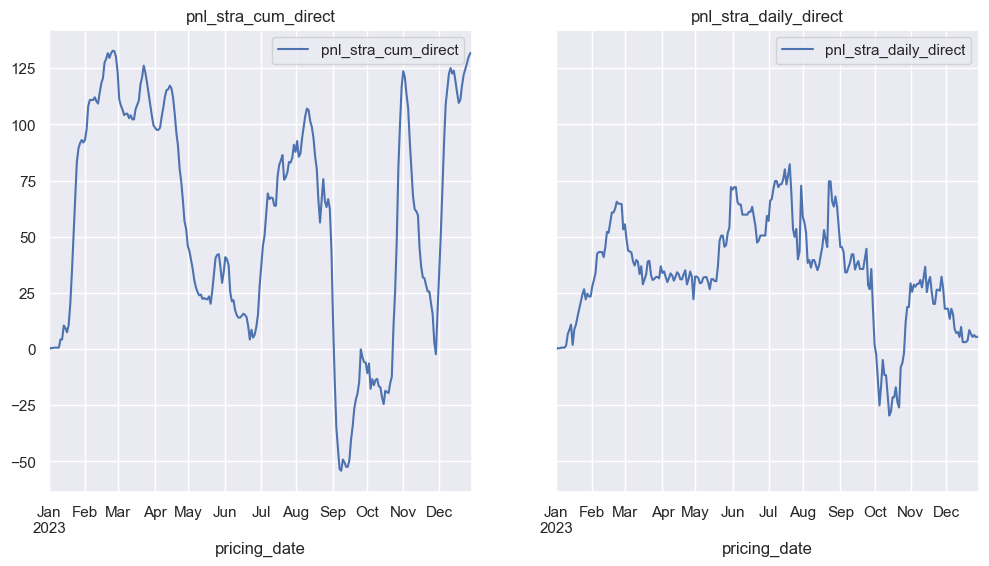

In [18]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard

target_col = 'target+10'

new_df['target+10'] = targets_df.loc[:, 'F380 M2/M3+1'].values


results = get_predictions(new_df.copy(), 'experiments/', test_start='2023-01-01', test_end='2023-12-31',
                          use_rolling=True, n_estimators=100, target_col='target+10')

test = new_df[(new_df.index >= '2023-01-01') & (new_df.index <= '2023-12-31')]
X_test, y_test = test.drop(columns=target_col), test[target_col]

X_test['rolling_target5'] = results['target_feature'].get_target_feature('2023-12-29', '2023-01-01', True)['predicted_feature'].values


X_test = X_test.astype('float64')
explainer = RegressionExplainer(results['model'], X_test, y_test)
ExplainerDashboard(explainer, depth=5).run()